# Set-up Python Environment

In [1]:
import bumps
from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty
from bumps.bounds import BoundedNormal

In [2]:
import scipy
from scipy.optimize import root_scalar
from scipy.optimize import root
from scipy.stats.mstats import mquantiles
import scipy.io
import pandas as pd

import io, os, sys, types
matplotlib_style = 'seaborn-whitegrid' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']

import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse

import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
from datetime import datetime
    

import numpy as np
import numpy.matlib

import time

In [3]:
import subprocess
import glob
import h5py


In [4]:
plt.rcParams['svg.fonttype'] = 'none'

# Build The Model Functions

Note that throughout this notebook 'first order' refers the the First-order model, 'second order' refers to the Weiss model, and 'Ising' refers to the Ising model, as the models for the temperature dependance of the magnetic component of diffraction intensity.

In [5]:
# Isothermal Functions:

def Gaussian(x, alpha):
    #Gaussian peak centered at 0, evaluated at x, with HWHM alpha
    sigma = alpha/(np.sqrt(2.0 * np.log(2)))
    G = (1/(sigma*np.sqrt(2.0* np.pi)))*np.exp(-(x**2.0)/(2.0*sigma**2.0))
    return G

def Lorentzian(x, gamma):
    #Return Lorentzian peak centered at 0, evaluated at x, with HWHM gamma    
    L = gamma/(np.pi*(x**2.0 + gamma**2.0))
    return L

def Pseudo_voigt(x, alpha, gamma):
  f_L = 2.0*gamma
  f_G = 2.0*alpha

  f = (f_G**5.0\
       + 2.69269*(f_G**4.0)*(f_L)\
       + 2.42843*(f_G**3.0)*(f_L**2.0)\
       + 4.47163*(f_G**2.0)*(f_L**3.0)\
       + 0.07842*(f_G)*(f_L**4.0)\
       + f_L**5.0)**(0.2)

  eta = 1.36603*(f_L/f) - 0.477*(f_L/f)**2.0 + 0.11116*(f_L/f)**3.0

  hwhm = f/2.0
  
  PV = eta*Lorentzian(x,hwhm) + (1.0-eta)*Gaussian(x, hwhm)
  return PV

def One_peak(x, alpha, gamma, peak, scale, back):
    #Alpha, gamma, peak, scale, back are all row vectors
    #x is a collum vector of the positions
    two_thetas = np.add(x, -peak)
    PV = Pseudo_voigt(two_thetas, alpha, gamma)
    scaled_PV = PV*scale
    I = scaled_PV + back
    return I

def Two_peak(x, alpha, gamma, peak, scale, alpha1, gamma1, peak1, scale1, back):
    #Alpha, gamma, peak, scale, back are all row vectors
    #x is a collum vector of the positions
    I1 = One_peak(x, alpha, gamma, peak, scale, 0.0)
    I2 = One_peak(x, alpha1, gamma1, peak1, scale1, 0.0)
    I = I1 + I2 + back
    return I

####################################################
# Thermal Functions:

# Define I vs. T for first order phase transition:
def first_order_I_vs_T(temperatures, TN, Sigma, K, BK):
    I = ((K/2)*(1 - scipy.special.erf((temperatures - TN)/(np.sqrt(2.0)*Sigma))))**2 + BK
    return I


# Define the Brillouin Function
def Brillouin_J(x, J):
    # x is a matrix
    # J is a row-vector
    
    f1 = (2*J+1)/(2*J) #factor 1
    f2 = 1/(2*J) #factor 2
    B_J = f1/(np.tanh(f1*x)) - f2/(np.tanh(f2*x))
    return B_J
                   
# Define the Wiess equation (re-arranged so that it always = 0)                  
def Wiess(t, m, J):
    # t is a collum vector
    # J is a row vector
    # m is a matrix
    
    f1 = 3.0*J/(J +1.0) # factor 1
    f2 = 1.0/t #factor 2
    
    m = np.ones_like(t)*m
    x = f1*m*f2
    
    
    W = m - Brillouin_J(x, J)
    return W.reshape(-1)

#Define a Magnetization Solver for givin t and J:
def Mag_solve(t, J):
    # t is a collum vector
    # J is a row vector
    
    def fun(x):
        x= x.reshape((t.shape[0], J.shape[1]))
        return Wiess(t, x, J)
    
    X0 = np.ones((t.shape[0], J.shape[1]), dtype=np.float64) # matrix of every t,J combination
    
    solution = root(fun, X0, method ='hybr')
    
    m = np.array(solution.x).reshape((t.shape[0], J.shape[1]))
    return m

#Define the Intensity as function of Temperature for Second order phase transitions using the Weiss Model
def second_order_I_vs_T(Temperatures, TN, M0, J, BK):
    # TN, M0, J, BK are row vectors
    TN = np.array(TN).reshape(1,-1)
    M0 = np.array(M0).reshape(1,-1)
    J = np.array(J).reshape(1,-1)
    BK = np.array(BK).reshape(1,-1)
    # Temperatures is a collumn vector
    Temperatures = Temperatures.reshape(-1,1)
    
    Inverse_TN = 1/TN
    
    t = Temperatures @ Inverse_TN #Create a matrix of every (temperature, TN) combination

    #Find where all the temperatures below the TN. 
    t_low_truth = t <1.0
    t_low_truth = t_low_truth.reshape(t.shape)
    t_low = t*t_low_truth
    
    #Because "Mag_solve" is expensive, only pass the non-zero rows of the t_low matrix.
    t_low_cut = t_low[t_low.sum(axis=1) !=0]

    #Calculate the reduced magnetization for below Tn\
    m_low = Mag_solve(t_low_cut, J) #returns a matrix where each collumn of m is associated with a collum of J
    
    #The mag is zero above the TN, construct that matrix
    m_high = np.zeros((t.shape[0]-t_low_cut.shape[0], t.shape[1]))
    #Combine the m matrixies for below and above the TN
    m = np.concatenate((m_low,m_high), axis=0)
    
    #"t_low_cut" could have a raggid bottom edge, so only keep the m values below the TN 
    m = m*t_low_truth

    #Calcualte the Magnetization (not reduced)
    M = m * M0 #row by row mulitplication of m by M0
    
    ##Calculate the intensities
    #Square of Magnetization
    I = M**2 
    
    #Add the background
    I = I + BK

    return I


def Ising_model_I_vs_T(Temperatures, TN, M0, BETA, BK):
    # TN, M0, J, BK are row vectors
    TN = np.array(TN).reshape(1,-1)
    M0 = np.array(M0).reshape(1,-1)
    BETA = np.array(BETA).reshape(1,-1).astype(np.complex128)
    BK = np.array(BK).reshape(1,-1)

    T_iw = np.array(0.5).reshape(1,-1)

    # Temperatures is a collumn vector
    Temperatures = Temperatures.reshape(-1,1)    
    Inverse_TN = 1/TN
    
    t = Temperatures @ Inverse_TN #Create a matrix of every (temperature, TN) combination
    
    #Cut out the temperatures where the Ising Model is not valid
    mask = np.logical_and(t<1.0, t>T_iw)
    
    t_eval = np.empty_like(t)
    t_eval[:] = np.nan
    t_eval[mask] = t[mask]

    I = (M0*((1 - t_eval)**(2*BETA)))**2 + BK
    I = I.astype(np.float64)

    #Above TN set the I to the background
    upper = t >= 1
    BK_matrix = np.matlib.repmat(BK, Temperatures.shape[0], 1)
    I[upper] = BK_matrix[upper]
    
    return I







## Thermal Model:

For use with the Ising model with bumps, define a new class that handles <code>np.nan</code> values of intensity outside the range of applicablity of the Ising model.  

In [6]:
import inspect
import warnings

import numpy as np
from numpy import log, pi, sqrt

from bumps.parameter import Parameter

def _parse_pars(fn, init=None, skip=0, name=""):
    """
    Extract parameter names from function definition.

    *fn* is the function definition.  This could be declared as
    *fn(p1, p2, p3, ...)* where *p1*, etc. are the fittable parameters.

    *init* is a dictionary of initial values for the parameters,
    overriding any default values.  If called from a constructor with
    **kwargs representing unknown named arguments, use *init=kwargs*.

    *skip* is the number of parameters to skip.  This will be *skip=0*
    for a function which defines the log likelihood directly or one
    that returns a set of residuals. For parameterized curves such as
    *fn(x, p1, p2, ...)* use *skip=1*.  For surfaces with
    *fn(x, y, p1, p2, ...)* use *skip=2*.

    *name* is added to each parameter name to differentiate it from other
    parameters in the same fit.

    A default value in the function definition such as *pk=value* will
    be set as the default value for the parameter.  If the default is
    *pk=None* then the parameter will be non-fittable, and instead set
    through *init*.
    """
    sig = inspect.signature(fn)
    params = sig.parameters.values()
    pnames = [p.name for p in params]
    
    valid = [p.kind in (inspect.Parameter.POSITIONAL_ONLY, inspect.Parameter.POSITIONAL_OR_KEYWORD) for p in params]
    if not all(valid):
        raise TypeError(f"Only positional and keyword arguments allowed for {fn.__name__}")

    # TODO: need "self" handling for passed methods
    # Skip the first argument if it is x or maybe skip x, y.
    pnames = pnames[skip:]

    # Parameters default to zero
    defaults = dict((p, 0) for p in pnames)

    # If the function provides default values, use those.
    for param in list(params)[skip:]:
        if param.default is not inspect.Parameter.empty:
            defaults[param.name] = param.default

    # Non-fittable parameters need to be sent in as None
    state_vars = set(p for p, v in defaults.items() if v is None)

    # Regardless, use any values specified in the constructor, but first
    # check that they exist as function parameters.
    invalid = set(init.keys()) - set(pnames)
    if invalid:
        raise TypeError("Invalid initializers: %s" %
                        ", ".join(sorted(invalid)))
    defaults.update(init)

    # Build parameters out of ranges and initial values
    # maybe:  name=(p+name if name.startswith('_') else name+p)
    pars = dict((p, Parameter.default(defaults[p], name=name + p))
                for p in pnames if p not in state_vars)

    state = dict((p, v) for p, v in defaults.items() if p in state_vars)

    #print("pars", pars)
    #print("state", state)
    return pars, state

def _assign_pars(obj, pars):
    # Make parameters accessible as model attributes
    for k, v in pars.items():
        if hasattr(obj, k):
            raise TypeError("Parameter cannot be named %s" % k)
        setattr(obj, k, v)
        
class Curve_w_nan(object):
    r"""
    Model a measurement with a user defined function.

    The function *fn(x,p1,p2,...)* should return the expected value *y* for
    each point *x* given the parameters *p1*, *p2*, etc.  *dy* is the
    uncertainty for each measured value *y*.  If not specified, it defaults
    to 1. Multi-valued functions, which return multiple *y* values for each
    *x* value, should have *x* as a vector of length *n* and *y*, *dy* as
    arrays of size *[n, k]*.

    Initial values for the parameters can be set as *p=value* arguments to
    *Curve*. If no value is set, then the initial value will be taken from
    the default value given in the definition of *fn*, or set to 0 if the
    parameter is not defined with an initial value.  Arbitrary non-fittable
    data can be passed to the function as parameters, but only if the
    parameter is given a default value of *None* in the function definition,
    and has the initial value set as an argument to *Curve*.  Defining
    *state=dict(key=value, ...)* before *Curve*, and calling *Curve* as
    *Curve(..., \*\*state)* works pretty well.

    *Curve* takes the following special keyword arguments:

    * *name* is added to each parameter name when the parameter is defined.
      The filename for the data is a good choice, since this allows you to keep
      the parameters straight when fitting multiple datasets simultaneously.

    * *plot* is an alternative plotting function. The function should be
      defined as *plot(x,y,dy,fy,\*\*kw)*. The keyword arguments will be
      filled with the values of the parameters used to compute *fy*.  It
      will be easiest to list the parameters you need to make your plot
      as positional arguments after *x,y,dy,fy* in the plot function
      declaration.  For example, *plot(x,y,dy,fy,p3,\*\*kw)* will make the
      value of parameter *p3* available as a variable in your function.  The
      special keyword *view* will be a string containing *linear*, *log*,
      *logx*, or *loglog*.  If only showing the residuals, the string
      will be *residual*.

    * *plot_x* is an array giving the sample points to use when plotting
      the theory function, if different from the *x* values at which the
      function is sampled.  Use this to draw a smooth curve between the
      fitted points.  This value is ignored if you provide your own plot
      function.

    * *labels* are the axis labels for the plot.  This should include
      units in parentheses. If the function is multi-valued then
      use *['x axis', 'y axis', 'line 1', 'line 2', ...]*.

    The data uncertainty is assumed to follow a gaussian distribution.
    If measurements draw from some other uncertainty distribution, then
    subclass Curve and replace nllf with the correct probability given the
    residuals.  See the implementation of :class:`PoissonCurve` for an example.
    """
    def __init__(self, fn, x, y, dy=None, name="", labels=None,
                 plot=None, plot_x=None, **kwargs):
        self.x, self.y = np.asarray(x), np.asarray(y)
        if dy is None:
            self.dy = 1
        else:
            self.dy = np.asarray(dy)
            if (self.dy <= 0).any():
                raise ValueError("measurement uncertainty must be positive")

        if len(self.x.shape) == 1 and len(self.y.shape) > 1:
            num_curves = self.y.shape[0]
        else:
            num_curves = 1
        self._num_curves = num_curves  # use same value everywhere

        # interpret labels parameter
        if labels is None:
            labels = ['x', 'y']
        elif len(labels) < 2 or len(labels) != num_curves+2:
            if num_curves > 1:
                lines = "line1, ..., line%d"%num_curves
            else:
                lines = "line"
            raise TypeError("labels should be [x, y, %s]"%lines)

        if len(labels) == 2:
            if num_curves > 1:
                line_labels = ['y%d'%k for k in range(num_curves)]
            else:
                line_labels = [labels[1]]
            labels = list(labels) + line_labels
        self.labels = labels


        # TODO: self.fn is a duplicate of self._function below. Deprecated?
        self.fn = fn
        self.name = name # if name else fn.__name__ + " "
        self.plot_x = plot_x

        pars, state = _parse_pars(fn, init=kwargs, skip=1)

        # Make parameters accessible as model attributes
        _assign_pars(self, pars)
        #_assign_pars(state, self)  # ... and state variables as well

        # Remember the function, parameters, and number of parameters
        # Note: we are remembering the parameter names and not the
        # parameters themselves so that the caller can tie parameters
        # together using model1.par = model2.par.  Otherwise we would
        # need to override __setattr__ to intercept assignment to the
        # parameter attributes and redirect them to the a _pars dictionary.
        # ... and similarly for state if we decide to make them attributes.
        self._function = fn
        self._pnames = list(sorted(pars.keys()))
        self._state = state
        self._plot = plot
        self._cached_theory = None

    def update(self):
        self._cached_theory = None


    def parameters(self):
        return dict((p, getattr(self, p)) for p in self._pnames)


    def numpoints(self):
        return np.prod(self.y.shape)


    def theory(self, x=None):
        # Use cache if x is None, otherwise compute theory with x.
        if x is None:
            if self._cached_theory is None:
                self._cached_theory = self._compute_theory(self.x)
            return self._cached_theory
        return self._compute_theory(x)


    def _compute_theory(self, x):
        kw = self._fetch_pars()
        return self._function(x, **kw)

    def _fetch_pars(self):
        kw = dict((p, getattr(self, p).value) for p in self._pnames)
        kw.update(self._state)
        return kw

    def simulate_data(self, noise=None):
        theory = self.theory()
        if noise is not None:
            if noise == 'data':
                pass
            elif noise < 0:
                self.dy = -0.01*noise*theory
            else:
                self.dy = noise
        self.y = theory + np.random.randn(*theory.shape)*self.dy


    def residuals(self):
        return (self.theory() - self.y) / self.dy


    def nllf(self):
        r = self.residuals()
        ####################################################
        ## Change from the standard curve class in bumps ##
        """Since our model can return np.nan values, the residuals will also be np.nan at those locations.
        We will just sum the residuals in the range where the model returns numbered values to get the likelihood."""
        ####################################################
        return 0.5 * np.nansum(r ** 2)


    def save(self, basename):
        # TODO: need header line with state vars as json
        # TODO: need to support nD x,y,dy
        if len(self.x.shape) > 1:
            warnings.warn("Save not supported for nD x values")
            return

        theory = self.theory()
        if self._num_curves > 1:
            # Multivalued y, dy for single valued x.
            columns = [self.x]
            headers = ["x"]
            for k, (y, dy, fx) in enumerate(zip(self.y, self.dy, theory)):
                columns.extend((y, dy, fx))
                headers.extend(("y[%d]"%(k+1), "dy[%d]"%(k+1), "fx[%d]"%(k+1)))
        else:
            # Single-valued y, dy for single valued x.
            headers = ["x", "y", "dy", "fy"]
            columns = [self.x, self.y, self.dy, theory]
        data = np.vstack(columns)
        outfile = basename + '.dat'
        with open(outfile, "w") as fd:
            fd.write("# " + "\t ".join(headers) + "\n")
            np.savetxt(fd, data.T)


    def plot(self, view=None):
        if self._plot is not None:
            kw = self._fetch_pars()
            self._plot(self.x, self.y, self.dy, self.theory(), view=view, **kw)
            return

        import pylab
        from .plotutil import coordinated_colors

        x = self.x
        if self.plot_x is not None:
            theory_x, theory_y = self.plot_x, self.theory(self.plot_x)
        else:
            theory_x, theory_y = x, self.theory()
        resid = self.residuals()

        if self._num_curves > 1:
            y, dy, theory_y, resid = self.y.T, self.dy.T, theory_y.T, resid.T
        else:
            y, dy, theory_y, resid = (v[:, None]
                                      for v in (self.y, self.dy, theory_y, resid))

        colors = tuple(coordinated_colors() for _ in range(self._num_curves))
        labels = self.labels

        #print "kw_plot",kw
        if view == 'residual':
            _plot_resids(x, resid, colors, labels=labels, view=view)
        else:
            plot_ratio = 4
            h = pylab.subplot2grid((plot_ratio, 1), (0, 0), rowspan=plot_ratio-1)
            for tick_label in h.get_xticklabels():
                tick_label.set_visible(False)
            _plot_fits(data=(x, y, dy), theory=(theory_x, theory_y),
                       colors=colors, labels=labels, view=view)
            #pylab.gca().xaxis.set_visible(False)
            #pylab.gca().spines['bottom'].set_visible(False)
            #pylab.gca().set_xticks([])

            pylab.subplot2grid((plot_ratio, 1), (plot_ratio-1, 0), sharex=h)
            _plot_resids(x, resid, colors=colors, labels=labels, view=view)


In [7]:
def First_order_model(X_grid, Y_grid):
    M = Curve(first_order_I_vs_T, X_grid, Y_grid, 
          dy = np.sqrt(Y_grid/100),
          TN = TN_guess, Sigma = Sigma_guess, K = K_guess , BK = BK_guess)

    M.TN.bounds = TN_dist
    M.Sigma.bounds = Sigma_dist
    M.K.bounds = K_dist
    M.BK.bounds = BK_dist
    
    if len(X_grid) < 5 :
        problem = FitProblem(M, partial = True)
    else:
        problem = FitProblem(M, partial = False)
    
    return problem

def Ising_model(X_grid, Y_grid):
    M = Curve_w_nan(Ising_model_I_vs_T, X_grid, Y_grid, 
          dy = np.sqrt(Y_grid/100),
          TN = TN_guess, M0 = M0_guess, BETA = BETA_guess , BK = BK_guess)

    M.TN.bounds = TN_dist
    M.M0.bounds = M0_dist
    M.BETA.bounds = BETA_dist
    M.BK.bounds = BK_dist
    problem = FitProblem(M, partial = True)
    
    return problem


def Second_order_model(X_grid, Y_grid):
    M = Curve(second_order_I_vs_T, X_grid, Y_grid, 
          dy = np.sqrt(Y_grid/100),
          TN = TN_guess, M0 = M0_guess, J = J_guess , BK = BK_guess)

    M.TN.bounds = TN_dist
    M.M0.bounds = M0_dist
    M.J.bounds = J_dist
    M.BK.bounds = BK_dist

    if len(X_grid) < 5 :
        problem = FitProblem(M, partial = True)
    else:
        problem = FitProblem(M, partial = False)
    
    return problem

In [8]:
def Thermal_inference_first_order_train(X_grid, Y_grid):
    problem = First_order_model(X_grid, Y_grid)
            
    method = 'dream' 
    
    print("initial chisq", problem.chisq_str())
    result = fit(problem, method=method, xtol=1e-6, ftol=1e-8, 
                 samples = 100000, 
                 burn = 100,
                 pop = 10,
                 init = 'eps',
                 thin = 1,
                 alpha = 0.1,
                 outliers = 'none',
                 trim = False,
                 steps = 0)
    print("final chisq", problem.chisq_str())
    for k, v, dv in zip(problem.labels(), result.x, result.dx):
        print(k, ":", format_uncertainty(v, dv))
        
    return problem, result

def Thermal_inference_Ising_model_train(X_grid, Y_grid):
    problem = Ising_model(X_grid, Y_grid)
            
    method = 'dream' 
    
    print("initial chisq", problem.chisq_str())
    result = fit(problem, method=method, xtol=1e-6, ftol=1e-8, 
                 samples = 100000, 
                 burn = 100,
                 pop = 10,
                 init = 'eps',
                 thin = 1,
                 alpha = 0.1,
                 outliers = 'none',
                 trim = False,
                 steps = 0)
    print("final chisq", problem.chisq_str())
    for k, v, dv in zip(problem.labels(), result.x, result.dx):
        print(k, ":", format_uncertainty(v, dv))
        
    return problem, result


def Thermal_inference_second_order_train(X_grid, Y_grid): 
    problem = Second_order_model(X_grid, Y_grid)

    method = 'dream' 
    
    print("initial chisq", problem.chisq_str())
    result = fit(problem, method=method, xtol=1e-6, ftol=1e-8, 
                 samples = 100000, 
                 burn = 100,
                 pop = 10,
                 init = 'eps',
                 thin = 1,
                 alpha = 0.1,
                 outliers = 'none',
                 trim = False,
                 steps = 0)
    print("final chisq", problem.chisq_str())
    for k, v, dv in zip(problem.labels(), result.x, result.dx):
        print(k, ":", format_uncertainty(v, dv))
        
    return problem, result
    

In [9]:
def Thermal_inference_first_order_predict(posterior_results, X_predict):
    #Extract the Posterior of the parameters
    draw = posterior_results.state.draw()
      
    #Posterior results are in alphabetical order
    Posterior_TN = draw.points[:,3].reshape(1,-1)
    Posterior_Sigma = draw.points[:,2].reshape(1,-1)
    Posterior_K = draw.points[:,1].reshape(1,-1)
    Posterior_BK = draw.points[:,0].reshape(1,-1)
  
    #Calcualte the mean of the parameters
    TN_mean = np.mean(Posterior_TN).reshape(1,-1)
    Sigma_mean = np.mean(Posterior_Sigma).reshape(1,-1)
    K_mean = np.mean(Posterior_K).reshape(1,-1)
    BK_mean = np.mean(Posterior_BK).reshape(1,-1)
    
    #Calculate the curve from the mean of the parameters
    Thermal_Mean_Posterior_parameter_curve = first_order_I_vs_T(X_predict,
                                                                TN_mean, Sigma_mean, K_mean, BK_mean)
    
    
    #Posterior results are in alphabetical order
    TN_best = posterior_results.state.best()[0][3]
    Sigma_best = posterior_results.state.best()[0][2]
    K_best = posterior_results.state.best()[0][1]
    BK_best = posterior_results.state.best()[0][0]
    
    #Calculate the curve from the BEST parameters
    Thermal_best_curve = first_order_I_vs_T(X_predict,
                                            TN_best, Sigma_best, K_best, BK_best)
    
    #Calculate the predicted curves from posterior sets of parameters
    print('Predicting')
    Thermal_CI_curves = first_order_I_vs_T(X_predict,
                                           Posterior_TN, Posterior_Sigma, Posterior_K, Posterior_BK)
        
    q = np.array([0.95, 0.05])
    I_ci = np.quantile(Thermal_CI_curves, q, axis=1)#.reshape((-1,2))
    Thermal_lower_curve = I_ci[1,:].reshape(-1,1)
    Thermal_upper_curve = I_ci[0,:].reshape(-1,1)
    
    Thermal_mean_of_posterior_curves = np.mean(Thermal_CI_curves, axis=1).reshape(-1,1)
    Thermal_variance = np.var(Thermal_CI_curves, axis=1).reshape(-1,1)
     
    dictionary = {'TN Mean':TN_mean, 
                  'Sigma Mean':Sigma_mean, 
                  'K Mean':K_mean, 
                  'BK Mean':BK_mean, 
                  'Thermal Mean Posterior Parameter Curve': Thermal_Mean_Posterior_parameter_curve,
                  'Thermal Best Parameter Curve':  Thermal_best_curve,
                  'Thermal Mean of Posterior Curves': Thermal_mean_of_posterior_curves,
                  'Thermal Variance': Thermal_variance,
                  'Thermal CI Curves': Thermal_CI_curves,
                  'Thermal lower Curve': Thermal_lower_curve,
                  'Thermal upper Curve': Thermal_upper_curve}
    
    return dictionary


In [10]:
def Thermal_inference_Ising_predict(posterior_results, X_predict):
    #Extract the Posterior of the parameters
    draw = posterior_results.state.draw()
      
    #Posterior results are in alphabetical order
    Posterior_TN = draw.points[:,3].reshape(1,-1)
    Posterior_M0 = draw.points[:,2].reshape(1,-1)
    Posterior_BETA = draw.points[:,0].reshape(1,-1)
    Posterior_BK = draw.points[:,1].reshape(1,-1)
  
    #Calcualte the mean of the parameters
    TN_mean = np.mean(Posterior_TN).reshape(1,-1)
    M0_mean = np.mean(Posterior_M0).reshape(1,-1)
    BETA_mean = np.mean(Posterior_BETA).reshape(1,-1)
    BK_mean = np.mean(Posterior_BK).reshape(1,-1)
    
    #Calculate the curve from the mean of the parameters
    Thermal_Mean_Posterior_parameter_curve = Ising_model_I_vs_T(X_predict,
                                                                TN_mean, M0_mean, BETA_mean, BK_mean)
    
    
    #Posterior results are in alphabetical order
    TN_best = posterior_results.state.best()[0][3]
    M0_best = posterior_results.state.best()[0][2]
    BETA_best = posterior_results.state.best()[0][0]
    BK_best = posterior_results.state.best()[0][1]
    
    #Calculate the curve from the BEST parameters
    Thermal_best_curve = Ising_model_I_vs_T(X_predict,
                                            TN_best, M0_best, BETA_best, BK_best)
    
    #Calculate the predicted curves from posterior sets of parameters
    print('Predicting')
    Thermal_CI_curves = Ising_model_I_vs_T(X_predict,
                                           Posterior_TN, Posterior_M0, Posterior_BETA, Posterior_BK)
        
    q = np.array([0.95, 0.05])
    I_ci = np.quantile(Thermal_CI_curves, q, axis=1)#.reshape((-1,2))
    Thermal_lower_curve = I_ci[1,:].reshape(-1,1)
    Thermal_upper_curve = I_ci[0,:].reshape(-1,1)
    
    Thermal_mean_of_posterior_curves = np.mean(Thermal_CI_curves, axis=1).reshape(-1,1)
    Thermal_variance = np.var(Thermal_CI_curves, axis=1).reshape(-1,1)
     
    dictionary = {'TN Mean':TN_mean, 
                  'M0 Mean':M0_mean, 
                  'BETA Mean':BETA_mean, 
                  'BK Mean':BK_mean, 
                  'Thermal Mean Posterior Parameter Curve': Thermal_Mean_Posterior_parameter_curve,
                  'Thermal Best Parameter Curve':  Thermal_best_curve,
                  'Thermal Mean of Posterior Curves': Thermal_mean_of_posterior_curves,
                  'Thermal Variance': Thermal_variance,
                  'Thermal CI Curves': Thermal_CI_curves,
                  'Thermal lower Curve': Thermal_lower_curve,
                  'Thermal upper Curve': Thermal_upper_curve}
    
    return dictionary


In [12]:
def Thermal_inference_second_order_predict(posterior_results, X_predict):
    #Extract the Posterior of the parameters
    draw = posterior_results.state.draw()
      
    #Posterior results are in alphabetical order
    Posterior_TN = draw.points[:,3]
    Posterior_M0 = draw.points[:,2]
    Posterior_J = draw.points[:,1]
    Posterior_BK = draw.points[:,0]
  
    #Calcualte the mean of the parameters
    TN_mean = np.mean(Posterior_TN).reshape(1,-1)
    M0_mean = np.mean(Posterior_M0).reshape(1,-1)
    J_mean = np.mean(Posterior_J).reshape(1,-1)
    BK_mean = np.mean(Posterior_BK).reshape(1,-1)
    
    #Calculate the curve from the mean of the parameters
    Thermal_Mean_Posterior_parameter_curve = second_order_I_vs_T(X_predict,
                                                                TN_mean, M0_mean, J_mean, BK_mean)
    
    
    #Posterior results are in alphabetical order
    TN_best = posterior_results.state.best()[0][3]
    M0_best = posterior_results.state.best()[0][2]
    J_best = posterior_results.state.best()[0][1]
    BK_best = posterior_results.state.best()[0][0]
    
    #Calculate the curve from the BEST parameters
    Thermal_best_curve = second_order_I_vs_T(X_predict,
                                            TN_best, M0_best, J_best, BK_best)
    
    #Calcualte all the predictive curves by interating through the posterior samples 
    print('Predicting')
    Thermal_CI_curves = np.empty((X_predict.shape[0],0))
    thin_posterior_TN_dist = Posterior_TN[::50]
    thin_posterior_M0_dist = Posterior_M0[::50]
    thin_posterior_J_dist = Posterior_J[::50]
    thin_posterior_BK_dist = Posterior_BK[::50]
    for i, _ in enumerate(thin_posterior_TN_dist):
        I_interem = second_order_I_vs_T(X_predict,
                                        TN=thin_posterior_TN_dist[i].reshape(1,-1), 
                                        M0=thin_posterior_M0_dist[i].reshape(1,-1),
                                        J=thin_posterior_J_dist[i].reshape(1,-1),
                                        BK=thin_posterior_BK_dist[i].reshape(1,-1))
        Thermal_CI_curves = np.concatenate((Thermal_CI_curves, I_interem), axis=1)
        
    q = np.array([0.95, 0.05])
    I_ci = np.quantile(Thermal_CI_curves, q, axis=1)#.reshape((-1,2))
    Thermal_lower_curve = I_ci[1,:].reshape(-1,1)
    Thermal_upper_curve = I_ci[0,:].reshape(-1,1)
    
    Thermal_mean_of_posterior_curves = np.mean(Thermal_CI_curves, axis=1).reshape(-1,1)
    Thermal_variance = np.var(Thermal_CI_curves, axis=1).reshape(-1,1)
     
    dictionary = {'TN Mean':TN_mean, 
                  'M0 Mean':M0_mean, 
                  'J Mean':J_mean, 
                  'BK Mean':BK_mean, 
                  'Thermal Mean Posterior Parameter Curve': Thermal_Mean_Posterior_parameter_curve,
                  'Thermal Best Parameter Curve':  Thermal_best_curve,
                  'Thermal Mean of Posterior Curves': Thermal_mean_of_posterior_curves,
                  'Thermal Variance': Thermal_variance,
                  'Thermal CI Curves': Thermal_CI_curves,
                  'Thermal lower Curve': Thermal_lower_curve,
                  'Thermal upper Curve': Thermal_upper_curve}
    
    return dictionary


In [13]:
def update_thermal_dataframe(dataframe, index, posterior_model, posterior_results, posterior_predictions):
    #Cycle Identifying
    dataframe.loc[index, 'Thermal Cycle'] = index
    
    #Likelihood:
    dataframe.loc[index, 'Likelihood'] = posterior_results.state.best()[1]
    
    #Input data
    dataframe.loc[index, 'Measured Temperatures'] = posterior_model.fitness.x
    dataframe.loc[index, 'Measured Max Intensities'] = posterior_model.fitness.y
    dataframe.loc[index, 'Measured Max Intensities Error'] = posterior_model.fitness.dy
    
    #Posterior Parameters
    draw = posterior_results.state.draw()
    
    dataframe.loc[index, 'Posterior Tn'] = draw.points[:,3].reshape(1,-1)
    dataframe.loc[index, 'Posterior M0'] = draw.points[:,2].reshape(1,-1)
    dataframe.loc[index, 'Posterior J'] = draw.points[:,1].reshape(1,-1)
    dataframe.loc[index, 'Posterior BK'] = draw.points[:,0].reshape(1,-1)
    
    dataframe.loc[index, 'Best Tn'] = posterior_results.state.best()[0][3]
    dataframe.loc[index, 'Best M0'] = posterior_results.state.best()[0][2]
    dataframe.loc[index, 'Best J'] = posterior_results.state.best()[0][1]
    dataframe.loc[index, 'Best BK'] = posterior_results.state.best()[0][0]
    
    dataframe.loc[index, 'Tn Std'] = posterior_results.dx[3]
    dataframe.loc[index, 'M0 Std'] = posterior_results.dx[2]
    dataframe.loc[index, 'J Std'] = posterior_results.dx[1]
    dataframe.loc[index, 'BK Std'] = posterior_results.dx[0]
    
    #Predictions
    dataframe.loc[index, 'Mean Parameter Curve'] = posterior_predictions['Thermal Mean Posterior Parameter Curve']
    dataframe.loc[index, 'Best Parameters Curve'] = posterior_predictions['Thermal Best Parameter Curve']
    dataframe.loc[index, 'Mean of Posterior Curves'] = posterior_predictions['Thermal Mean of Posterior Curves']
    dataframe.loc[index, 'Variance'] = posterior_predictions['Thermal Variance']
    dataframe.loc[index, 'Confidence Interval Curves'] = posterior_predictions['Thermal CI Curves']
    dataframe.loc[index, 'Lower Bound'] = posterior_predictions['Thermal lower Curve']
    dataframe.loc[index, 'Upper Bound'] = posterior_predictions['Thermal upper Curve']
    
    #Next sample
    dataframe.loc[index, 'Next Temperature'] = posterior_predictions['Thermal Next Temperature']
    dataframe.loc[index, 'Bravery Factor'] = posterior_predictions['Bravery Factor']
    dataframe.loc[index, 'Above TN'] = posterior_predictions['Above TN']
        
    return dataframe

In [14]:
def plot_thermal_inference(temperatures, posterior_predictions, posterior_model, dataframe, Hist = True, Name= None):
    Mean_of_curves = posterior_predictions['Thermal Mean of Posterior Curves']
    Best_parameter_curve = posterior_predictions['Thermal Best Parameter Curve']
    Parameter_mean = posterior_predictions['Thermal Mean Posterior Parameter Curve']
    Upper = posterior_predictions['Thermal upper Curve']
    Lower = posterior_predictions['Thermal lower Curve']
    Next = posterior_predictions['Thermal Next Temperature']
    
    Measured_Temperatures = posterior_model.fitness.x
    Measured_I            = posterior_model.fitness.y
    Measured_Ierror       = posterior_model.fitness.dy
    
    plt.figure(figsize=(10,10))
    plt.title('Thermal Predictions')
    plt.errorbar(Measured_Temperatures.reshape(-1), Measured_I.reshape(-1), yerr= Measured_Ierror.reshape(-1), fmt = 'bo', label = 'Measured Data')
    plt.fill_between(temperatures.flatten(),Upper.flatten(), Lower.flatten(), alpha=0.7,color="#7A68A6", label = 'Cofidence Interval')
    plt.plot(temperatures, Mean_of_curves, 'r-', linewidth=7.0, label = 'Mean of Posterior Curves')
    plt.plot(temperatures, Best_parameter_curve, 'k--', label = 'Best Parameters')
#     plt.plot(temperatures, Parameter_mean, 'k--', label = 'Mean of Parameters')
    plt.vlines(Next, ymin =np.min(Lower) , ymax = np.max(Upper),colors= 'g', label='Next Sample')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Intensity (arb. units)')
    plt.legend()
    if Name != None:
        plt.savefig(f"{Name}.svg")
    plt.show()
    
    if Hist == True:
        
        #The posterior distributions are not all the same size, so draw a set number of sampels from them. 
        hist_size=10000
        
        posterior_TN_distributions = np.empty((hist_size, 0))
        posterior_M0_distributions = np.empty((hist_size, 0))
        posterior_J_distributions = np.empty((hist_size, 0))
        posterior_BK_distributions = np.empty((hist_size, 0))
        
        for i, _ in enumerate(dataframe.index):
            temp_TN = np.random.choice(dataframe['Posterior Tn'][i].flatten(), hist_size).reshape(-1,1)
            temp_M0 = np.random.choice(dataframe['Posterior M0'][i].flatten(), hist_size).reshape(-1,1)
            temp_J = np.random.choice(dataframe['Posterior J'][i].flatten(), hist_size).reshape(-1,1)
            temp_BK = np.random.choice(dataframe['Posterior BK'][i].flatten(), hist_size).reshape(-1,1)

            posterior_TN_distributions = np.concatenate((posterior_TN_distributions, temp_TN), axis = 1)
            posterior_M0_distributions = np.concatenate((posterior_M0_distributions, temp_M0), axis = 1)
            posterior_J_distributions = np.concatenate((posterior_J_distributions, temp_J), axis = 1)
            posterior_BK_distributions = np.concatenate((posterior_BK_distributions, temp_BK), axis = 1)

        a = np.linspace(1,posterior_TN_distributions.shape[1],posterior_TN_distributions.shape[1])
        A = np.matlib.repmat(a, posterior_TN_distributions.shape[0], 1)

        h0, Aedges, TN_edges = np.histogram2d(A.flatten(), posterior_TN_distributions.flatten(), bins=[A.shape[1], 256])
        h1, Aedges, M0_edges = np.histogram2d(A.flatten(), posterior_M0_distributions.flatten(), bins=[A.shape[1], 256])
        h2, Aedges, J_edges = np.histogram2d(A.flatten(), posterior_J_distributions.flatten(), bins=[A.shape[1], 256])
        h3, Aedges, BK_edges = np.histogram2d(A.flatten(), posterior_BK_distributions.flatten(), bins=[A.shape[1], 256])
        
        cmap = plt.cm.plasma.copy()
        cmap.set_bad(cmap(0))
        
        plt.figure(figsize=(10,10))
        
        plt.subplot(2,2,1)
        plt.pcolormesh(Aedges, TN_edges, h0.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h0)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("TN")
        
        plt.subplot(2,2,2)
        plt.pcolormesh(Aedges, M0_edges, h1.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h1)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("M0")
        
        plt.subplot(2,2,3)
        plt.pcolormesh(Aedges, J_edges, h2.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h2)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("J")

        plt.subplot(2,2,4)
        plt.pcolormesh(Aedges, BK_edges, h3.T, cmap=cmap,
                                 rasterized=False, norm=LogNorm(vmax=np.max(h3)))
        # plt.colorbar(label="# points", pad=0)
        plt.colorbar(label="# points")
        plt.xticks(np.arange(min(a), max(a)+1, 1.0))
        plt.title("BK")

        plt.show()


In [15]:
def update_first_order_dataframe(dataframe, index, posterior_model, posterior_results, posterior_predictions):
    #Cycle Identifying
    dataframe.loc[index, 'Thermal Cycle'] = index
    
    #Likelihood:
    dataframe.loc[index, 'Likelihood'] = posterior_results.state.best()[1]
    
    #Input data
    dataframe.loc[index, 'Measured Temperatures'] = posterior_model.fitness.x
    dataframe.loc[index, 'Measured Max Intensities'] = posterior_model.fitness.y
    
    #Posterior Parameters
    draw = posterior_results.state.draw()
    
    dataframe.loc[index, 'Posterior Tn'] = draw.points[:,3].reshape(1,-1)
    dataframe.loc[index, 'Posterior Sigma'] = draw.points[:,2].reshape(1,-1)
    dataframe.loc[index, 'Posterior K'] = draw.points[:,1].reshape(1,-1)
    dataframe.loc[index, 'Posterior BK'] = draw.points[:,0].reshape(1,-1)
    
    dataframe.loc[index, 'Best Tn'] = posterior_results.state.best()[0][3]
    dataframe.loc[index, 'Best Sigma'] = posterior_results.state.best()[0][2]
    dataframe.loc[index, 'Best K'] = posterior_results.state.best()[0][1]
    dataframe.loc[index, 'Best BK'] = posterior_results.state.best()[0][0]
    
    dataframe.loc[index, 'Tn Std'] = posterior_results.dx[3]
    dataframe.loc[index, 'Sigma Std'] = posterior_results.dx[2]
    dataframe.loc[index, 'K Std'] = posterior_results.dx[1]
    dataframe.loc[index, 'BK Std'] = posterior_results.dx[0]
    
    #Predictions
    dataframe.loc[index, 'Mean Parameter Curve'] = posterior_predictions['Thermal Mean Posterior Parameter Curve']
    dataframe.loc[index, 'Best Parameters Curve'] = posterior_predictions['Thermal Best Parameter Curve']
    dataframe.loc[index, 'Mean of Posterior Curves'] = posterior_predictions['Thermal Mean of Posterior Curves']
    dataframe.loc[index, 'Variance'] = posterior_predictions['Thermal Variance']
    dataframe.loc[index, 'Confidence Interval Curves'] = posterior_predictions['Thermal CI Curves']
    dataframe.loc[index, 'Lower Bound'] = posterior_predictions['Thermal lower Curve']
    dataframe.loc[index, 'Upper Bound'] = posterior_predictions['Thermal upper Curve']
    
    #Next sample
    dataframe.loc[index, 'Next Temperature'] = posterior_predictions['Thermal Next Temperature']

   
    return dataframe

# Build the Inference Loop

## Import the Data

Import the log files generated during the autonomous run

In [18]:
filename = 'Thermal_Outputs_run1_2021-08-02.p'

therm_read = pd.read_pickle(filename)

In [19]:
Measured_temperatures = therm_read['Measured Temperatures'][therm_read.index[-1]]

In [20]:
Measured_tempature_dependent_Intensities = therm_read['Measured Max Intensities'][therm_read.index[-1]]

In [21]:
T2 = therm_read['Temperatures'][0]

In [22]:
filename = 'Isothermal_Outputs_run1_2021-08-02.p'

iso_read = pd.read_pickle(filename)

In [23]:
Backgrounds = iso_read['Best Back'].to_numpy().reshape(-1,1)

Subtract the Isothermal Background from the Magnetic component of the intensity

In [24]:
Measured_tempature_dependent_Intensities_minus_back = Measured_tempature_dependent_Intensities - Backgrounds

In [25]:
Measured_tempature_dependent_Intensities_minus_back = Measured_tempature_dependent_Intensities_minus_back.astype(np.float64)

In [26]:
max_error = np.sqrt(therm_read['Measured Max Intensities Error'][therm_read.index[-1]][0][0])

Remove the large datafile from memory

In [27]:
del therm_read
del iso_read

In [28]:
dictionary_for_histograms = None

## Model Priors

In [40]:
# ## Define the priors on the Isothermal parameters ########
# Magnetic Peak Parameters
#Transition Temperature
TN_guess = 40.0
TN_std = 20
TN_limits = (0.001, 70.0)

#Background
BK_guess = 70.0
BK_std = 20.0
BK_limits = (0.0, 200.0)

#Second Order Scale
M0_guess = np.sqrt(Measured_tempature_dependent_Intensities_minus_back[0][0])
M0_std = max_error
M0_limits = (M0_guess-1.5*M0_std, M0_guess+1.5*M0_std)
# M0_limits = (M0_guess-1.5*M0_std, M0_guess+15.0*M0_std)

#Total Anglular Momentum
J_guess = 1.5
J_std = 2.0
J_limits = (0.01, 14.0)

#First Order transition width
Sigma_guess = 4.0
Sigma_std = 2.0
Sigma_limits = (0.0, 150.0)

#First Order Scale
K_guess = M0_guess
K_std = M0_std
K_limits = M0_limits

BETA_guess = 0.0826
BETA_std = 0.02
BETA_limits = (0.0, 1.0)

T_iw_guess = 0.00000001
T_iw_std = 0.00000001
T_iw_limits = (0.0, 0.0000001)

#Define the prior distributions
TN_dist =  BoundedNormal(TN_guess, TN_std, limits=TN_limits)
M0_dist =  BoundedNormal(M0_guess, M0_std, limits=M0_limits)
J_dist =  BoundedNormal(J_guess, J_std, limits=J_limits)
BK_dist =  BoundedNormal(BK_guess, BK_std, limits=BK_limits)

Sigma_dist =  BoundedNormal(Sigma_guess, Sigma_std, limits=Sigma_limits)
K_dist =  BoundedNormal(K_guess, K_std, limits=K_limits)
BETA_dist = BoundedNormal(BETA_guess, BETA_std, limits=BETA_limits)
T_iw_dist = BoundedNormal(T_iw_guess, T_iw_std, limits=T_iw_limits)

# First Order Fit

initial chisq 310499.58(47) constraints=12.1913
# steps: 2500, # draws: 100000
final chisq 10.21(47) constraints=12.9561
BK : 0.846(45)
K : 5.161(22)
Sigma : 6.04(29)
TN : 68.58(16)
Loglikelyhood =  -63.98454362545109
Predicting


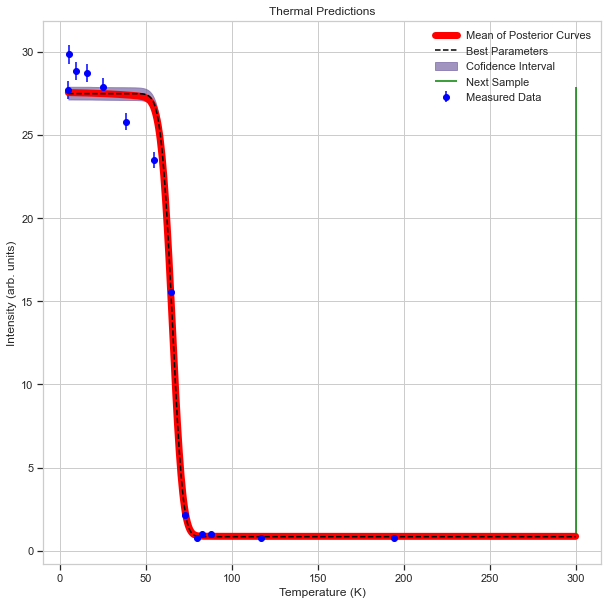

In [30]:
#Train
Thermal_posterior_first_model, Thermal_posterior_first_results = Thermal_inference_first_order_train(Measured_temperatures, 
                                                           Measured_tempature_dependent_Intensities_minus_back)

print('Loglikelyhood = ', Thermal_posterior_first_results.state.best()[1])
#Predict
Thermal_first_predictions = Thermal_inference_first_order_predict(Thermal_posterior_first_results, T2)
Thermal_first_predictions['Thermal Next Temperature'] =  T2[-1]

#Plot the results curves
plot_thermal_inference(T2, Thermal_first_predictions, Thermal_posterior_first_model, dictionary_for_histograms, Hist = False)

## Wiess Equation Fit

initial chisq 309634.91(47) constraints=11.4131
# steps: 2500, # draws: 100000
final chisq 67.02(47) constraints=12.6907
BK : 1.039(44)
J : 11(21)e-3
M0 : 5.366(22)
TN : 70.000(15)
Loglikelyhood =  -347.78580369489833
Predicting


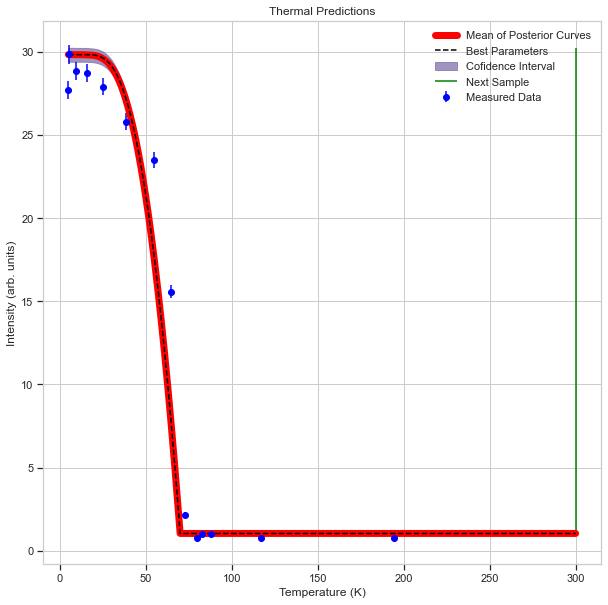

In [31]:
#Train
Thermal_posterior_model, Thermal_posterior_results = Thermal_inference_second_order_train(Measured_temperatures, 
                                                           Measured_tempature_dependent_Intensities_minus_back)

print('Loglikelyhood = ', Thermal_posterior_results.state.best()[1])
#Predict
Thermal_predictions = Thermal_inference_second_order_predict(Thermal_posterior_results, T2)
Thermal_predictions['Thermal Next Temperature'] =  T2[-1]

#Plot the results curves
plot_thermal_inference(T2, Thermal_predictions, Thermal_posterior_model, dictionary_for_histograms, Hist = False)


## Ising Model Fit

<ipython-input-5-24199b3b3b97>:173: RuntimeWarning: invalid value encountered in power
  I = (M0*((1 - t_eval)**(2*BETA)))**2 + BK
<ipython-input-5-24199b3b3b97>:174: ComplexWarning: Casting complex values to real discards the imaginary part
  I = I.astype(np.float64)


initial chisq 216733.90(34) constraints=8.32428
# steps: 2500, # draws: 100000
final chisq 5.77(34) constraints=8.32575
BETA : 0.0263(91)
BK : 0.960(42)
M0 : 5.23(12)
TN : 65.05(60)
Loglikelyhood =  -48.73950937306957
Predicting


C:\Users\asm6\Anaconda3\envs\ornl_al\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


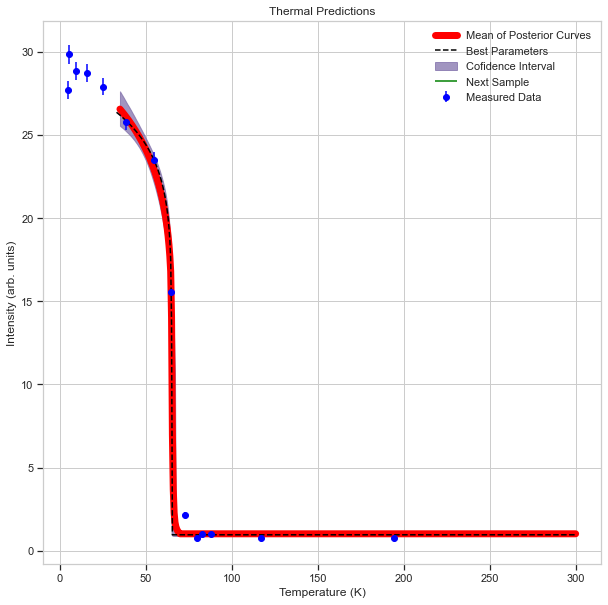

In [41]:
#Train
Thermal_posterior_Ising_model, Thermal_posterior_Ising_results = Thermal_inference_Ising_model_train(Measured_temperatures, 
                                                           Measured_tempature_dependent_Intensities_minus_back)

print('Loglikelyhood = ', Thermal_posterior_Ising_results.state.best()[1])

Thermal_Ising_predictions = Thermal_inference_Ising_predict(Thermal_posterior_Ising_results, T2)
Thermal_Ising_predictions['Thermal Next Temperature'] =  T2[-1]

#Plot the results curves
plot_thermal_inference(T2, Thermal_Ising_predictions, Thermal_posterior_Ising_model, dictionary_for_histograms, Hist = False, Name = 'Figure 6')

In [33]:

#Cut measurements above the TN
used_measurements = Measured_temperatures[Measured_temperatures<Thermal_posterior_Ising_results.state.best()[0][3]]

#Cut measurements below the appliablity
relevant_index = np.nanargmax(Thermal_Ising_predictions['Thermal Best Parameter Curve'])
used_measurements = used_measurements[used_measurements>T2[relevant_index]]

#Count number of measurements
used_measurements = used_measurements.shape[0]
print('Number of measurements used for fit = ', used_measurements)

Number of measurements used for fit =  3


## Given the range of applicablility of the Ising Model, re-run the inference for the other models for a fair comparison of likelihoods

In [34]:
TN_ising = Thermal_posterior_Ising_results.state.best()[0][3]

mask = Measured_temperatures > 0.5*TN_ising

Measured_temperatures_cut = Measured_temperatures[mask].reshape(-1,1)
Measured_tempature_dependent_Intensities_minus_back_cut = Measured_tempature_dependent_Intensities_minus_back[mask].reshape(-1,1)

### First order inference given the Ising Range

initial chisq 604273.96(94) constraints=12.1913
# steps: 2500, # draws: 100000
final chisq 3.30(94) constraints=12.7675
BK : 0.859(45)
K : 4.881(41)
Sigma : 5.34(23)
TN : 69.09(18)
Loglikelyhood =  -21.01354220115916
Predicting


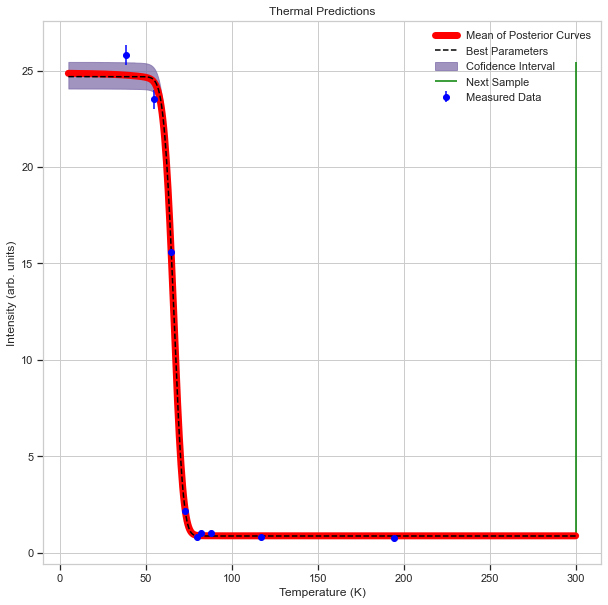

In [35]:
#Train
Thermal_posterior_first_model_cut, Thermal_posterior_first_results_cut = Thermal_inference_first_order_train(Measured_temperatures_cut, 
                                                           Measured_tempature_dependent_Intensities_minus_back_cut)

print('Loglikelyhood = ', Thermal_posterior_first_results_cut.state.best()[1])
#Predict
Thermal_first_predictions_cut = Thermal_inference_first_order_predict(Thermal_posterior_first_results_cut, T2)
Thermal_first_predictions_cut['Thermal Next Temperature'] =  T2[-1]

#Plot the results curves
plot_thermal_inference(T2, Thermal_first_predictions_cut, Thermal_posterior_first_model_cut, dictionary_for_histograms, Hist = False)

### Second order inference given the Ising Range

initial chisq 603552.57(94) constraints=11.4131
# steps: 2500, # draws: 100000
final chisq 109.88(94) constraints=12.7499
BK : 1.020(43)
J : 15(31)e-3
M0 : 5.739(43)
TN : 70.000(17)
Loglikelyhood =  -287.4429968027467
Predicting


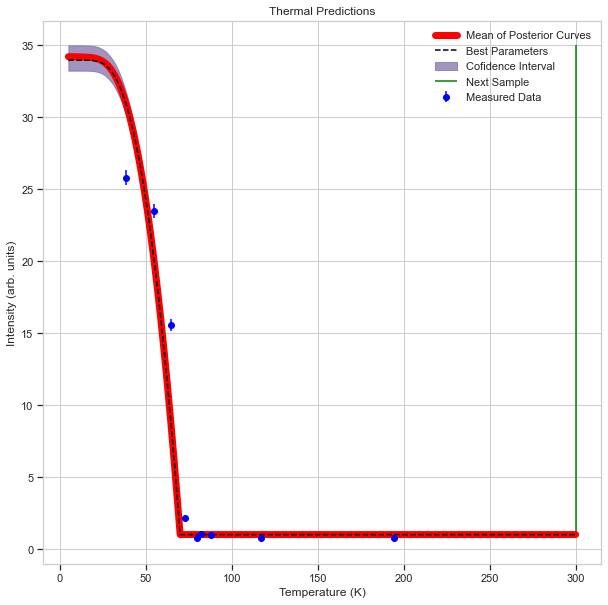

In [36]:
#Train
Thermal_posterior_model_cut, Thermal_posterior_results_cut = Thermal_inference_second_order_train(Measured_temperatures_cut, 
                                                           Measured_tempature_dependent_Intensities_minus_back_cut)

print('Loglikelyhood = ', Thermal_posterior_results_cut.state.best()[1])
#Predict
Thermal_predictions_cut = Thermal_inference_second_order_predict(Thermal_posterior_results_cut, T2)
Thermal_predictions_cut['Thermal Next Temperature'] =  T2[-1]

#Plot the results curves
plot_thermal_inference(T2, Thermal_predictions_cut, Thermal_posterior_model_cut, dictionary_for_histograms, Hist = False)


## Now let's see which is the best with the Bayes factor test

In [42]:
list_of_models = ['First Order', 'Second Order', 'Ising']
list_of_likelihoods = np.array([Thermal_posterior_first_results_cut.state.best()[1],
                               Thermal_posterior_results_cut.state.best()[1],
                               Thermal_posterior_Ising_results.state.best()[1]])

print('Model LogLikelihoods Given the Range of Temperatures where the Ising Model is Applicable:')
print(list_of_models[0], list_of_likelihoods[0], '\n',
            list_of_models[1], list_of_likelihoods[1], '\n',
            list_of_models[2], list_of_likelihoods[2])

best = np.argmax(list_of_likelihoods)
if best == 2:
    print('The most likely model is:', list_of_models[best])
    
else:
    list_of_likelihoods = np.array([Thermal_posterior_first_results.state.best()[1],
                                  Thermal_posterior_results.state.best()[1]])
    
    best = np.argmax(list_of_likelihoods)
    print('Model LogLikelihoods Given whole Range of Temperatures:')
    print(list_of_models[0], list_of_likelihoods[0], '\n',
            list_of_models[1], list_of_likelihoods[1])
    print('The most likely model is:', list_of_models[best])

Model LogLikelihoods Given the Range of Temperatures where the Ising Model is Applicable:
First Order -21.01354220115916 
 Second Order -287.4429968027467 
 Ising -48.73950937306957
Model LogLikelihoods Given whole Range of Temperatures:
First Order -63.98454362545109 
 Second Order -347.78580369489833
The most likely model is: First Order
